In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150.

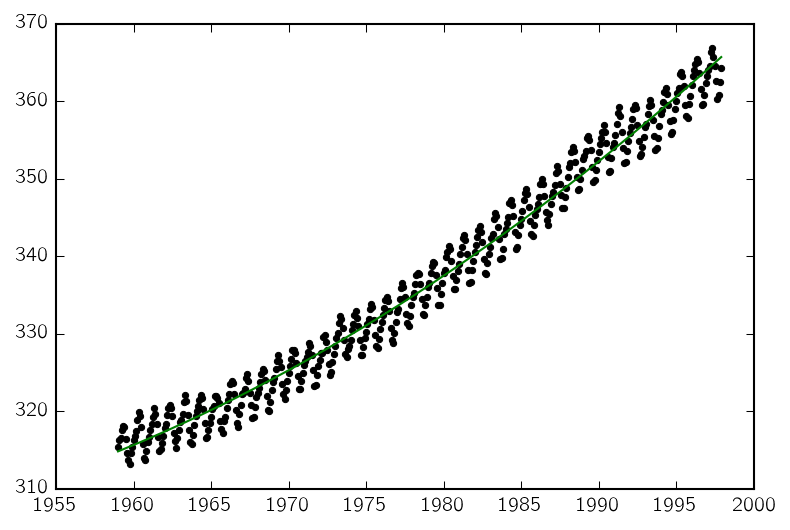

In [86]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as pl

data = sm.datasets.get_rdataset("co2").data
t = np.array(data.time)
y = np.array(data.co2)

A = np.vander(t, 3)
w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, y))
mu = np.dot(A, w)

pl.plot(t, y, ".k")
pl.plot(t, mu, "g");

In [87]:
from genrp import GP, kernels

In [99]:
kernel = kernels.RealTerm(np.var(y), 0.0)
kernel += kernels.RealTerm(np.var(y), 0.0)
kernel += kernels.ComplexTerm(np.var(y), 1.0, 0.0, 0.0)
kernel += kernels.Matern32Term(np.log(np.var(y)), 0.0)
kernel += kernels.SHOTerm(np.log(np.var(y)), 2.0, np.log(2*np.pi))
kernel += kernels.SHOTerm(np.log(np.var(y)), 2.0, np.log(2*np.pi))
gp = GP(kernel, log_white_noise=np.log(0.1), fit_white_noise=True)
# gp.add_term(np.var(y), 0.0)
# gp.add_term(np.var(y), 5.0)
# gp.add_term(np.var(y), 1.0)
# # gp.add_term(np.var(y), 1.0)
# gp.add_term(np.var(y), 2.0, 0.0)
# gp.add_term(np.var(y), 1.0, 0.0)
# gp.add_term(np.var(y), 1.0, 0.0)
# gp.add_term(np.var(y), 1.0, 0.0)

In [100]:
gp.compute(t)
gp.log_likelihood(y - mu)

LinAlgError: invalid parameters

In [101]:
v = gp.get_parameter_vector()
gp.set_parameter_vector(v)

In [102]:
from scipy.optimize import minimize

def nll(theta):
    gp.set_parameter_vector(theta)
    try:
        ll = gp.log_likelihood(y - mu)
    except np.linalg.LinAlgError:
        return 1e10
    if not np.isfinite(ll):
        return 1e10
    return -ll

def min_nll(p):
    result = minimize(nll, p, method="L-BFGS-B", bounds=[(-30, 30) for _ in range(len(p))])
    print(result.status, result.fun, result.x)
    return result

In [ ]:
results = list(map(
    min_nll, np.random.uniform(-1, 2, (50, len(gp)))
))
i = np.argmin([r.fun for r in results])
result = results[i]

2 10000000000.0 [ 1.93751224  0.70918011  1.22362595  1.55725137 -0.87160076  0.10138641
 -0.01476987 -0.13487091 -0.67354604  1.66870842 -0.47031049 -0.20248669
  0.38879198  1.35562931  1.91342755  1.8882962   0.85077542]
0 2236.07034934 [-0.87826453  1.71478682 -0.13705499 -0.07284239  0.26228007 -0.20769464
  0.53296685 -0.76723112 -0.02822413 -0.62453451  1.00751055 -0.88749724
  1.1792824   0.2777305   0.69770733 -0.45565949  1.27874399]
0 2259.61052163 [-0.38386188  1.18750936  0.10953524  1.91034107  0.60965223  1.26307075
  0.60862925  1.87317825  1.34130835  1.44121963  0.5547386   1.20280216
  0.65858818 -0.34732668 -0.68665744  0.50110876 -0.97256155]
0 10000000000.0 [ 1.21715809  1.17171782  0.64875408 -0.62730119  0.08350859  0.95013665
  1.09554876 -0.90853161  1.19495418  0.80033626 -0.46635915  1.92122863
  0.86209189  0.30597856 -0.99628324 -0.00925    -0.96123424]
0 10000000000.0 [-0.47652504 -0.99632807  1.99600048  1.58985634  1.69330234  1.05286221
  1.57332457 -0

In [ ]:
result

In [ ]:
gp.set_parameter_vector(result.x)
gp.compute(t)

In [ ]:
K = gp.get_matrix(t)
K[np.diag_indices_from(K)] += np.exp(gp.log_white_noise)
# x = np.linspace(max(t)-5, max(t)+25, 5000)
x = np.linspace(min(t), 2025, 5000)
Ks = gp.get_matrix(x, t)

In [ ]:
B = np.vander(x, len(w))
mean_pred = np.dot(B, w)
pred = mean_pred + np.dot(Ks, np.linalg.solve(K, y - mu))
std = np.sqrt(np.diag(gp.get_matrix(x, x) - np.dot(Ks, np.linalg.solve(K, Ks.T))))

In [ ]:
m = (t <= x.max()) * (t >= x.min())
pl.plot(t[m], y[m], ".k")
pl.plot(x, mean_pred, "b")
pl.fill_between(x, pred + std, pred - std, color="g", alpha=0.5)
pl.plot(x, pred, "g");

In [ ]:
freq = np.exp(np.linspace(-10.0, 5.0, 5000))
power = gp.get_kernel_psd(freq)
pl.plot(freq, power, "k")
pl.xscale("log")
pl.yscale("log")